<h1>Semantic_Segmentation_and_Background_Separation</h1>

<h2>라이브러리</h2>

In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2

<h2>model 불러오기</h2>

In [15]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
#50,101 있는데 deeplab 101 사용 , pretrained true 해야 weight 받아옴

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/jingon/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:03<00:00, 51.5MB/s] 
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/jingon/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:04<00:00, 53.7MB/s] 


<h2>Create Color Palette</h2>

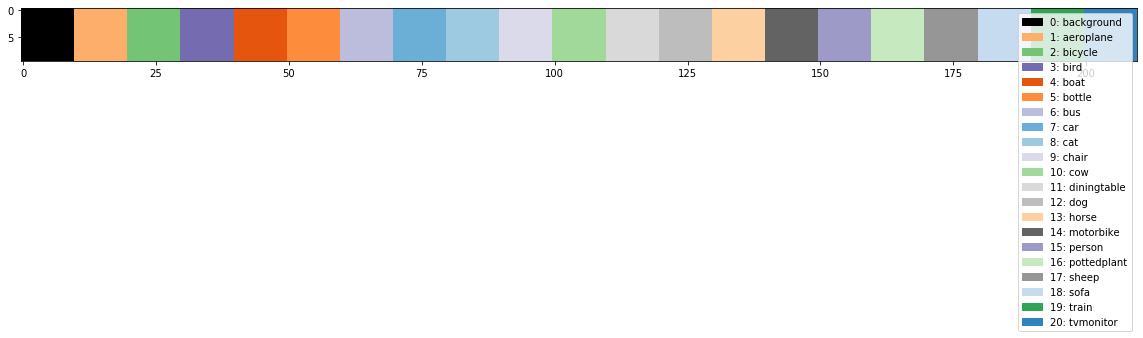

In [18]:
labels=['background','aeroplane','bicycle','bird','boat','bottle','bus','car','cat',
       'chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

cmap=plt.cm.get_cmap('tab20c')

colors = (cmap(np.arange(cmap.N))*255).astype(np.int)[:,:3].tolist()
np.random.seed(2020)
np.random.shuffle(colors)
colors.insert(0,[0,0,0])#background must be black
colors =np.array(colors, dtype=np.uint8)
palette_map=np.empty((10,0,3),dtype=np.uint8)
legend=[]
for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i])/255.,label='%d: %s'%(i,labels[i])))
    c=np.full((10,10,3),colors[i],dtype=np.uint8)
    palette_map=np.concatenate([palette_map,c],axis=1)
    
plt.figure(figsize=(20,2))
plt.legend(handles=legend)
plt.imshow(palette_map)

<h2>Segment Function</h2>

In [42]:
def segment(net,img):
    preprocess = transforms.Compose([ #이미지 전처리 모듈
        transforms.ToTensor(), # tensor 형태로 만들어줌
        transforms.Normalize( # 정규화 해줌
        mean=[0.485,0.486,0.406],
        std=[0.229,0.224,0.225]
        ),
    ])
    input_tensor =preprocess(img) #(3,이미지세로크기,이미지가로크기)
    input_batch = input_tensor.unsqueeze(0)#0번에 새로운 축 추가 (1,3,세,가)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
         
    output =model(input_batch)['out'][0]#(21,height,width) 
    output_predictions = output.argmax(0).byte().cpu().numpy()#(height,width)
    # argmax(0) : 각 픽셀의 채널 방향으로 최소값을 채널 인덱스를 반환
    # byte() : uint8 변환
    # cpu() : cuda ->cpu
    #numpy():tensor->numpy ndarray
    r=Image.fromarray(output_predictions).resize((img.shape[1],img.shape[0]))
    #numpy ndarray를 pillow image 타입으로 변환
    # resize로 크기 변형
    r.putpalette(colors)
    
    return r, output_predictions

<h2> Result</h2>


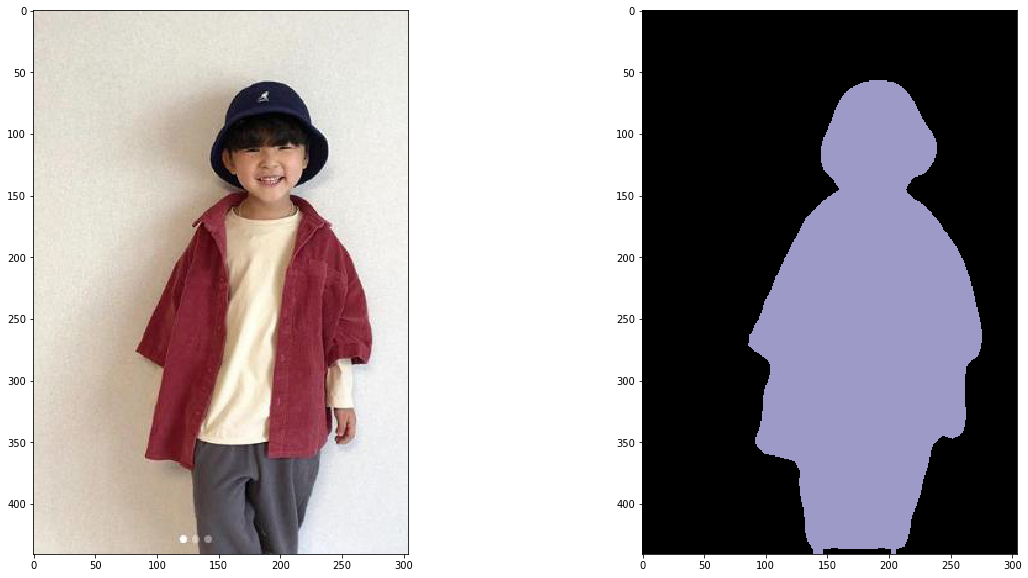

In [61]:
img = np.array(Image.open('imgs/yunsang.jpg'))
fg_h,fg_w,_=img.shape
segment_map,pred =segment(model,img)

fig,axes =plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(img)
axes[1].imshow(segment_map) 

<h2>Load Backgroud Image and Resize</h2>

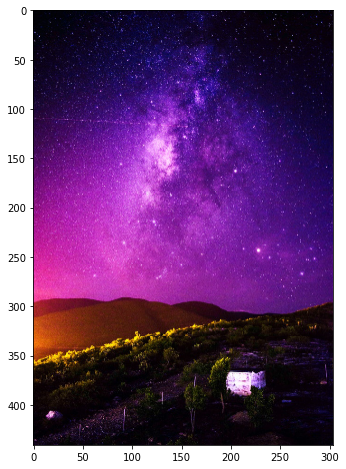

In [62]:
# 크기 figure 사진이랑 같게 만들기 

background = np.array(Image.open('imgs/bg02.jpg'))

bg_h, bg_w, _ = background.shape

background = cv2.resize(background, dsize=(fg_w, int(fg_w*bg_h/bg_w)))

bg_h, bg_w, _ = background.shape


margin= (bg_h - fg_h) // 2  

#가로 맞춘 뒤 세로는 margin 만큼 맞추기

if margin>0:
    background = background[margin:-margin,:,:]
else :
    background = cv2.copyMakeBorder(background,top=abs(margin),bottom=abs(margin),left=0,right=0,borderType=cv2.BORDER_REPLICATE)
    
    #copyMakeBorder() : 이미지 경계선을 만들거나 픽셀을 복사해 이미지의 크기 늘림
    #REPLICATE: 복사해서 크게 해줌 


#final resize

background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12,8))
plt.imshow(background)

<h2> 배경과 사진 이미지 뽑아오기 </h2>

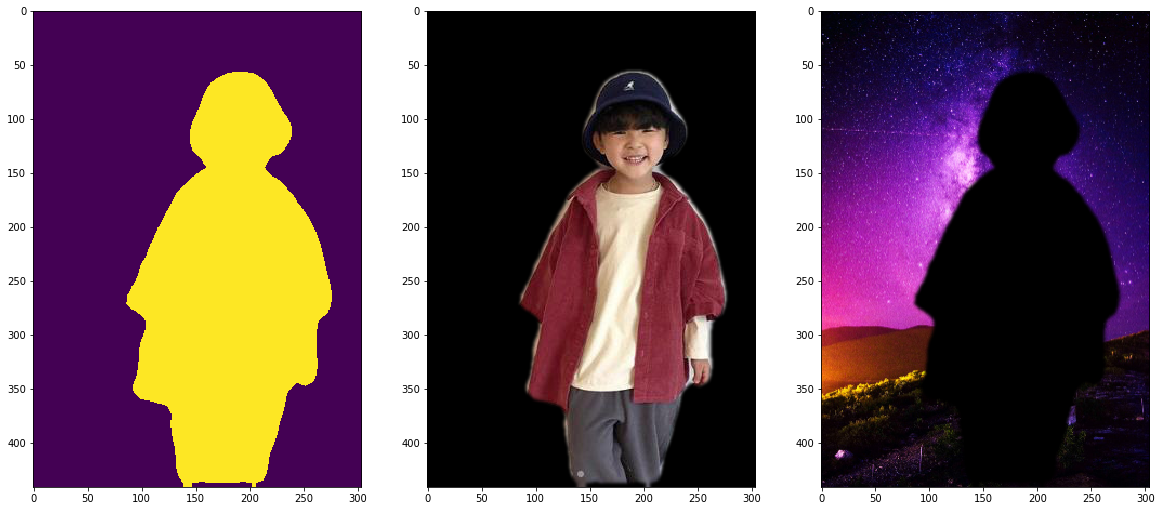

In [63]:
mask =(pred==15).astype(float)*255 ##사람 있는 곳만 255만 된다 나머진 0 
_,alpha =cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
#threshold() : 임계값 처리로 바이너리 마스크를 만든다 
#마스크를 바이너리형태로 만들어서 0,255 만 가지게 만듦
alpha=cv2.GaussianBlur(alpha,(7,7),0).astype(float)
#cv2.gaussianblur() 이미지  흐릿하게 만듦
alpha = alpha / 255. # (0~1사이 값), (height,width) 구조 
alpha = np.repeat(np.expand_dims(alpha,axis=2),3,axis=2) #연산하려면 이미지 같은 구조인 (h,w,3)만듦
#3배로 복사

forground =cv2.multiply(alpha,img.astype(float))
background = cv2.multiply(1.-alpha,background.astype(float))


fig, axes = plt.subplots(1,3, figsize = (20,10))
axes[0].imshow(mask)
axes[1].imshow(forground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

<h2>result</h2>

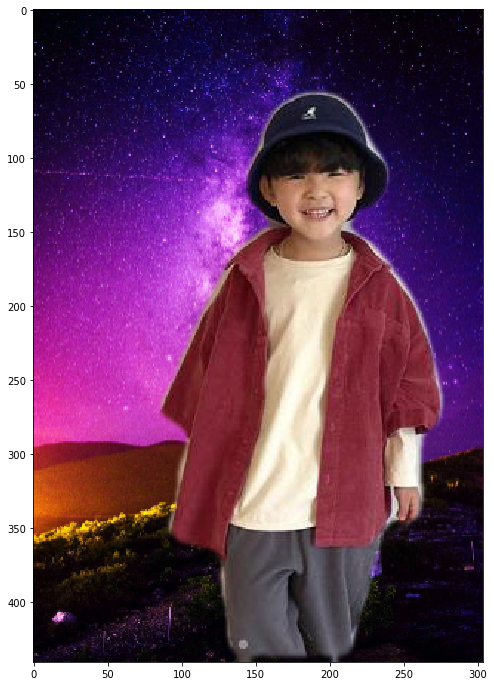

In [64]:
result = cv2.add(forground,background).astype(np.uint8)
Image.fromarray(result).save('imgs/result.jpg')

plt.figure(figsize=(12,12))
plt.imshow(result)